In [1]:
from sentence_transformers import SentenceTransformer, models, util
from nltk import word_tokenize
from collections import defaultdict
import matplotlib.pyplot as plt
import sbert_training
import pandas as pd
import copy
import torch
import sys
import pickle

In [2]:
#!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [3]:
word_tokenizer = word_tokenize
device = "cuda:0" if torch.cuda.is_available() else "cpu"
repo_dir = "/home/marcelbraasch/PycharmProjects/argmining-21-keypoint-analysis-sharedtask-code-2/"

In [4]:
def save_with_pickle(path, data):
    with open(path, "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_from_pickle(path):
    data = None
    with open(path, "rb") as handle:
        data = pickle.load(handle)
    return data

In [5]:
def load_model():
    try:
        path = "/home/marcelbraasch/PycharmProjects/argmining-21-keypoint-analysis-sharedtask-code/model"
        model = SentenceTransformer(path)
    except:
        model = sbert_training.train_model('/home/marcelbraasch/PycharmProjects/argmining-21-keypoint-analysis-sharedtask-code-2/data/siamese-data/',
                                           "/home/marcelbraasch/PycharmProjects/argmining-21-keypoint-analysis-sharedtask-code-2/data/kpm_data",
                                           'dev',
                                           "/home/marcelbraasch/PycharmProjects/new_KPA/argmining-21-keypoint-analysis-sharedtask-code-2/code/siamese-models",
                                           'roberta-base',
                                           model_suffix='contrastive-10-epochs',
                                           data_file_suffix='contrastive',
                                          num_epochs=10, max_seq_length=70, add_special_token=True, train_batch_size=32, loss='ContrastiveLoss')
    return model

In [6]:
model = load_model()

2022-01-23 14:41:49 - Load pretrained SentenceTransformer: /home/marcelbraasch/PycharmProjects/argmining-21-keypoint-analysis-sharedtask-code/model
2022-01-23 14:41:50 - Use pytorch device: cuda


In [7]:
def create_arg_kps_mapping(arguments_df, key_points_df):
    mapping = {}
    topics = arguments_df["topic"].unique()
    for topic in topics:
        arguments = arguments_df.loc[arguments_df["topic"] == topic][["argument"]].drop_duplicates()
        key_points = key_points_df.loc[key_points_df["topic"] == topic][["key_point"]].drop_duplicates()
        map = pd.merge(arguments, key_points, how="cross")
        mapping[topic] = map
    return mapping

def load_kpm_data(model):

    path = "gold_labels_and_prediction_scores.pkl"

    try:
        return load_from_pickle(path)
    except:
        pass

    data = defaultdict(dict)
    for subset in ["dev"]:#, "train"]:
        # Load files
        arguments_file = repo_dir + f"data/kpm_data/arguments_{subset}.csv"
        key_points_file = repo_dir + f"data/kpm_data/key_points_{subset}.csv"
        labels_file = repo_dir + f"data/kpm_data/labels_{subset}.csv"
        arguments_df = pd.read_csv(arguments_file)
        key_points_df = pd.read_csv(key_points_file)
        labels_df = pd.read_csv(labels_file)

        # Get gold standard
        positive_labels_df = labels_df.loc[labels_df["label"] == 1]
        gold_standard = pd.merge(positive_labels_df, key_points_df, how="inner", on="key_point_id")
        gold_standard = pd.merge(gold_standard, arguments_df, how="inner", on=["arg_id","topic"])
        gold_standard = gold_standard[["topic", "argument", "key_point"]]
        gold_standard["score"] = 1
        data[subset]["gold_standard"] = gold_standard

        # Compute model scores
        def compute_score_from(row):
            argument = row["argument"]
            key_point = row["key_point"]
            return compute_entailment(argument, key_point, model)

        mappings = []
        arg_to_kps = create_arg_kps_mapping(arguments_df, key_points_df)
        for topic, arg_kps_mapping in arg_to_kps.items():
            arg_kps_mapping['score'] = arg_kps_mapping.apply(lambda row: compute_score_from(row), axis=1)
            arg_kps_mapping['topic'] = topic
            arg_kps_mapping = arg_kps_mapping[["topic", "argument", "key_point", "score"]]
            mappings.append(arg_kps_mapping)
        predictions = pd.concat(mappings, axis=0)
        data[subset]["predictions"] = predictions

        save_with_pickle(path, data)

    return data

In [8]:
def compute_entailment(arg, kp, model):
    arg = model.encode(arg, show_progress_bar=False),
    kp = model.encode(kp, show_progress_bar=False)
    return float(util.pytorch_cos_sim(arg, kp))

In [9]:
def tokenize_kp(row):
    return word_tokenizer(row["key_point"])

def _leave_one_out(row):
    words = row["key_point_words"]
    samples = [{"dropped": "Reference", "new_kp": row["key_point"], "score": row["score"]}]
    for i in range(len(words)):
        new_kp = copy.deepcopy(words)
        dropped_word = new_kp.pop(i)
        new_kp = " ".join(new_kp)
        new_score = compute_entailment(row["argument"], new_kp, model)
        samples.append({"dropped": dropped_word, "new_kp": new_kp, "score": new_score})
    return samples

def leave_one_out(model):
    path = "leave_one_out.pkl"

    try:
        return load_from_pickle(path)
    except:
        pass

    # Iterates over the kpm data dict and compute leave one out for each entry
    dfs = load_kpm_data(model)
    for gold_or_pred in dfs.values():
        for df in gold_or_pred.values():
            df["key_point_words"] = df.apply(lambda row: tokenize_kp(row), axis=1)
            df["leave_one_out"] = df.apply(lambda row: _leave_one_out(row), axis=1)
    save_with_pickle(path, dfs)

    return dfs

In [10]:
model = load_model()
data = leave_one_out(model)

2022-01-23 14:41:50 - Load pretrained SentenceTransformer: /home/marcelbraasch/PycharmProjects/argmining-21-keypoint-analysis-sharedtask-code/model
2022-01-23 14:41:51 - Use pytorch device: cuda


In [33]:
def get_max_kp_for_arg(preds):
    max_map = defaultdict(dict)
    for row in preds.iterrows():
        row = row[1]
        argument, key_point, score = row["argument"], row["key_point"], row["score"]
        if max_map[argument] == {}:
            max_map[argument] = {"key_point": key_point, "score": score}
        elif max_map[argument]["score"] < score:
            max_map[argument] = {"key_point": key_point, "score": score}
    return max_map

def is_maximum(row, max_map):
    if max_map[row["argument"]]["key_point"] == row["key_point"]:
        return 1
    else:
        return 0

preds = data["dev"]["predictions"]
max_map = get_max_kp_for_arg(preds)
preds["is_max"] = preds.apply(lambda row: is_maximum(row, max_map), axis=1)
best_arg_kps = preds.loc[preds['is_max'] == 1]

KeyboardInterrupt: 

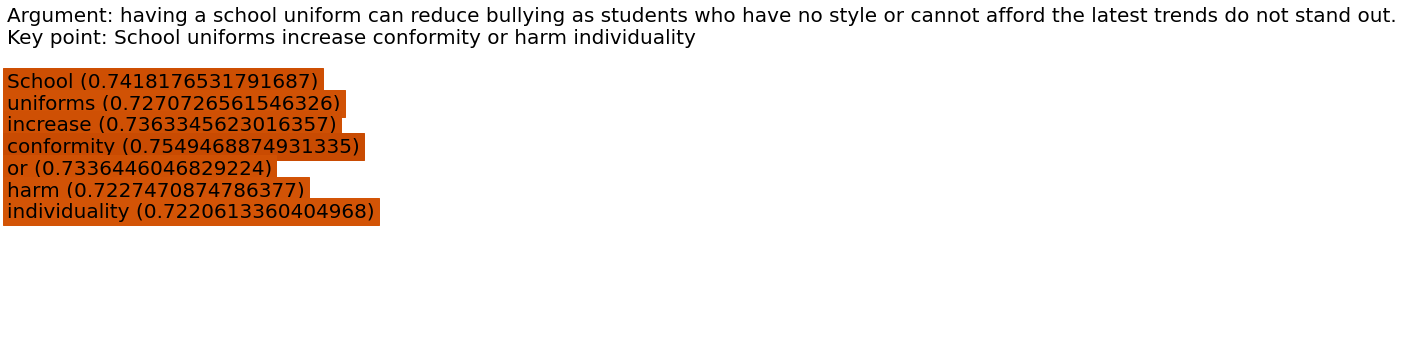

In [31]:
cmap = plt.cm.get_cmap('YlOrBr')

s = 0
counter = 0
for sample in best_arg_kps.iterrows():
    leave_one_out_sample = sample[1]["leave_one_out"]

    plt.text(0,1.5,f"Argument: {sample[1]['argument']}", fontsize=20)
    plt.text(0,1.4,f"Key point: {sample[1]['key_point']}", fontsize=20)

    _max = max([leave_one_out_sample[i]["score"]
               for i in range(1, len(leave_one_out_sample))])

    y_coord = 1.2
    for i in range(1, len(leave_one_out_sample)):
        word = leave_one_out_sample[i]["dropped"]
        importance = leave_one_out_sample[i]["score"] #- _max
        plt.text(0,y_coord,f"{word} ({importance})", fontsize=20, backgroundcolor=cmap(importance))
        y_coord -= 0.1
    plt.axis('off')
    # _in = input()
    # if _in == "exit":
    break
    # plt.figure().clear()
    # plt.close()
    # plt.cla()
    # plt.clf()

In [17]:










# import shap
# import transformers
# import nlp
# import torch
# import numpy as np
# import scipy as sp
#
# # load a BERT sentiment analysis model
# tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
# model = transformers.DistilBertForSequenceClassification.from_pretrained(
#     "distilbert-base-uncased-finetuned-sst-2-english"
# ).cuda()
#
# # define a prediction function
# def f(x):
#     tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
#     outputs = model(tv)[0].detach().cpu().numpy()
#     scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
#     val = sp.special.logit(scores[:,1]) # use one vs rest logit units
#     return val
#
# def compute_entailment_2(arg_kp, model):
#     arg = "".join(arg_kp.split("<SEP>")[0])
#     kp = "".join(arg_kp.split("<SEP>")[1])
#     arg = model.encode(arg, show_progress_bar=False),
#     kp = model.encode(kp, show_progress_bar=False)
#     return float(util.pytorch_cos_sim(arg, kp))
#
# def f2(x):
#     return float(util.pytorch_cos_sim(*x))
#
# def tokenizer2(x):
#     arg1 = "".join(x.split("<SEP>")[0])
#     arg2 = "".join(x.split("<SEP>")[1])
#     arg1 = model.encode(arg1, show_progress_bar=False),
#     arg2 = model.encode(arg2, show_progress_bar=False)
#     return (arg1, arg2)
#
# # build an explainer using a token masker
# data = {"label": [1],
#         "text": ["test1 test1 <SEP> test2 test2"]}
#
#
#
# # test_string = "test1 test1 <SEP> test2 test2"
# # compute_entailment_2(test_string, model)
# # explainer = shap.Explainer(compute_entailment, model.encode)
# # shap_values = explainer(data)#, fixed_context=1)
#
#
# # explain the model's predictions on IMDB reviews
# explainer = shap.Explainer(f2, tokenizer2)
#
# # imdb_train = nlp.load_dataset("imdb")["train"]
#
# shap_values = explainer(data)# fixed_context=1)